# MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

Is was adapted by Paul Ohm of Georgetown Law for a demo for Computer Programming for Lawyers on November 7, 2023. It is almost entirely based on this github repo (with minor edits and comments for pedagogical reasons):

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [ ]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

In [ ]:
# 70,000 images to be labeled
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [ ]:
# Look at one sample
n = 1500
X[n]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [ ]:
# And what is it's label?
y[n]

np.int64(9)

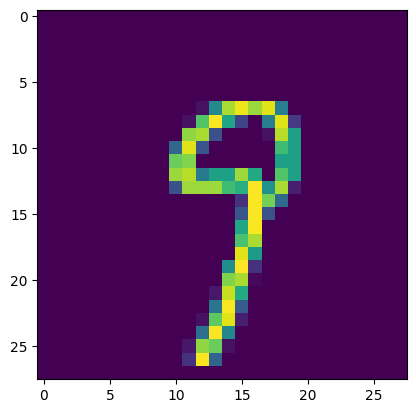

In [ ]:
# And what does it look like?
img = X[n].reshape(28, 28)
plt.imshow(img)

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(np.float32(0.0), np.float32(1.0))

Note: data is not normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((52500, 784), (52500,), (17500, 784), (17500,))

### Print a selection of training images and their labels

In [ ]:
#import random

def plot_example(X, y, n=5):
    """Plot a randomly generated n images and their labels in a row."""
    idx = np.random.choice(np.arange(len(X)), n, replace=False)
    X_sample = X[idx]
    y_sample = y[idx]
    for i, (img, y) in enumerate(zip(X_sample.reshape(n, 28, 28), y_sample)):
        plt.subplot(1, n, 1 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)
    return(idx)

def plot_example_three(X, y, z, n=5):
    """Plot a randomly generated n images and their labels in a row."""
    idx = np.random.choice(np.arange(len(X)), n, replace=False)
    X_sample = X[idx]
    y_sample = y[idx]
    z_sample = z[idx]
    for i, (img, y, z) in enumerate(zip(X_sample.reshape(n, 28, 28), y_sample, z_sample)):
        plt.subplot(1, n, 1 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"label = {z}\nguess = {y}")
    return(idx)

array([20474, 39944, 21435, 35473,  7157])

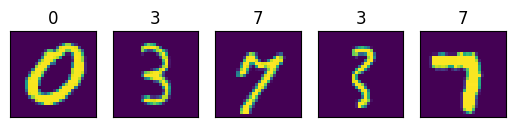

In [ ]:
plot_example(X_train, y_train, 5)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
# Specifies whether we are using GPUs (CUDA is something NVIDIA has created for parallel training of NNs on GPUs)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [ ]:
# Probably the most important block. This one defines how to
# set up the entire neural network.
# 14 lines of code to do so much!
class ClassifierModule(nn.Module):

    # Setting up the architecture of the NN itself
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            # Dropout randomly drops some nodes across the hidden layers (here 50% of them!)
            # in each iteration as a way to combat overfitting
            # good explanation at https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    # The method for the feed-forward phase
    def forward(self, X, **kwargs):
        # Uses the ReLU activation function (as opposed to sigmoid, etc)
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        # Softmax to normalize the output layer
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
# Important: will get the same result every time because of the seed.
torch.manual_seed(0)

# Now create an instance of the net you defined above!
# lr is the learning rate (multiplier of errors during backpropagation)
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8387       0.8800        0.4174  1.4267
      2        0.4332       0.9103        0.3133  0.8687
      3        0.3612       0.9233        0.2684  0.8628
      4        0.3233       0.9309        0.2317  1.0876
      5        0.2938       0.9353        0.2173  1.1626
      6        0.2738       0.9390        0.2039  1.0221
      7        0.2600       0.9454        0.1868  0.8722
      8        0.2427       0.9484        0.1757  0.8633
      9        0.2362       0.9503        0.1683  0.8741
     10        0.2226       0.9512        0.1621  0.8743
     11        0.2184       0.9529        0.1565  0.8683
     12        0.2090       0.9541        0.1508  0.8985
     13        0.2067       0.9570        0.1446  0.8912
     14        0.1978       0.9570        0.1412  0.9253
     15        0.1923       0.9582        0.1392  0.9207
     16        0.1889       0.9

## Prediction

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Make predictions of every image in the test set (17,500 images)
y_pred = net.predict(X_test)

In [ ]:
# And see how many are correct by comparing them to ground truth
accuracy_score(y_test, y_pred)

0.9631428571428572

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [ ]:
error_mask = y_pred != y_test

In [ ]:
len(y_pred[error_mask])

645

In [ ]:
# Out of how many?
len(y_test)

17500

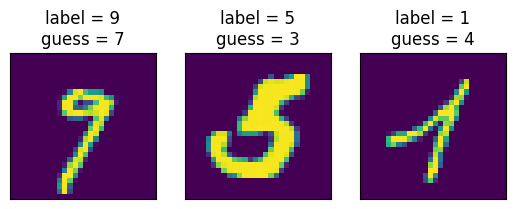

In [ ]:
random_is = plot_example_three(X_test[error_mask], y_pred[error_mask], y_test[error_mask], 3)

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

In [ ]:
# Start with original data
XCnn = X.reshape(-1, 1, 28, 28)

In [ ]:
XCnn.shape

(70000, 1, 28, 28)

In [ ]:
# New test/train splits starting with original data
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [ ]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        # First set of convolutions, with 3x3 kernel size
        # 1 input channel and 32 output channels
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)

        # Second set of convolutions, with 3x3 kernel size again
        # 32 input channels and 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)

        # Used to flatten back to output layer size
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4315       0.9723        0.0882  1.8560
      2        0.1645       0.9790        0.0677  1.6361
      3        0.1358       0.9831        0.0542  1.5945
      4        0.1155       0.9849        0.0501  1.4023
      5        0.0999       0.9869        0.0429  1.3970
      6        0.0966       0.9877        0.0399  1.3975
      7        0.0864       0.9868        0.0420  1.4022
      8        0.0850       0.9887        0.0396  1.4083
      9        0.0793       0.9874        0.0400  1.4231
     10        0.0750       0.9881        0.0405  1.5553


In [ ]:
y_pred_cnn = cnn.predict(XCnn_test)

In [ ]:
accuracy_score(y_test, y_pred_cnn)

0.9876

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [ ]:
error_mask_cnn = y_pred_cnn != y_test

In [ ]:
len(y_pred[error_mask_cnn])

217

In [ ]:
len(y_test)

17500

Over 70% of the previously misclassified images are now correctly identified.

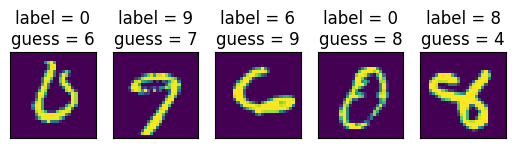

In [ ]:
random_is = plot_example_three(X_test[error_mask_cnn], y_pred_cnn[error_mask_cnn], y_test[error_mask_cnn], 5)

Characterize errors that one model made that the other did not

# CNN fixed the problem

Start with errors made by the non-CNN model that were fixed by the CNN model

In [ ]:
only_cnn_correct = error_mask & ~error_mask_cnn

In [ ]:
len(y_pred[only_cnn_correct])

489

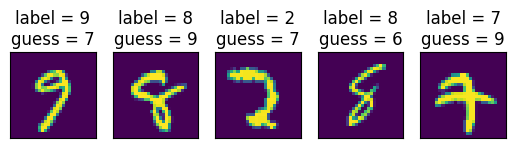

In [ ]:
random_is = plot_example_three(X_test[only_cnn_correct], y_pred[only_cnn_correct], y_test[only_cnn_correct], 5)

# CNN made a new problem

Now errors introduced by the CNN model that the old model got right!

In [ ]:
only_cnn_wrong = error_mask_cnn & ~error_mask

In [ ]:
len(y_pred[only_cnn_wrong])

61

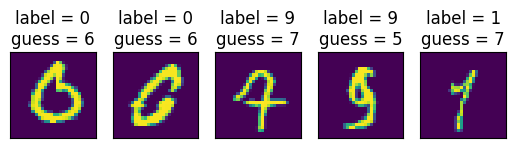

In [ ]:
random_is = plot_example_three(X_test[only_cnn_wrong], y_pred_cnn[only_cnn_wrong], y_test[only_cnn_wrong], 5)